# W2(I)_Choosing Features & Metrics for Nearest Neighbor Search

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix # compressed sparse row matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
data = pd.read_csv('people_wiki.csv')
data.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)

In [4]:
word_count = load_sparse_csr('people_wiki_word_count.npz') # sparse matrix
word_count # 59071 docs, 547979 words

<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [5]:
ser = pd.read_json('people_wiki_map_index_to_word.json', typ='series')
ser[:5]

0        540315
00       536260
000      535641
0000      83348
00000     81527
dtype: int64

In [6]:
word_index_dic = ser.to_dict()
# word_index_dic

In [7]:
def unpack_dict(matrix, word_index_dic):
    table = sorted(word_index_dic, key=word_index_dic.get)
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    num_doc = matrix.shape[0]
    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]]], data[indptr[i]:indptr[i+1]].tolist())} for i in range(num_doc)]

data['word_count'] = unpack_dict(word_count, word_index_dic)

In [8]:
data['index'] = np.array(range(len(data)))

In [9]:
cols = ['index', 'name', 'text', 'word_count','URI']
data = data[cols]
data.shape

(59071, 5)

In [10]:
data.head()

,index,name,text,word_count,URI
0,0,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",<http://dbpedia.org/resource/Digby_Morrell>
1,1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",<http://dbpedia.org/resource/Alfred_J._Lewy>
2,2,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",<http://dbpedia.org/resource/Harpdog_Brown>
3,3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",<http://dbpedia.org/resource/Franz_Rottensteiner>
4,4,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",<http://dbpedia.org/resource/G-Enka>


In [11]:
# use word count vectors to represent the articles and Euclidean distance to measure distance
model = NearestNeighbors(metric='euclidean', algorithm='brute').fit(word_count)

In [12]:
data[data['name']=='Barack Obama']

,index,name,text,word_count,URI
35817,35817,Barack Obama,barack hussein obama ii brk husen bm born augu...,"{'husen': 1, '2012obama': 1, 'laureateduring':...",<http://dbpedia.org/resource/Barack_Obama>


In [13]:
# use 'Barack Obama' as the query point
distances, indexes = model.kneighbors(word_count[35817], n_neighbors=10)

In [14]:
neighbors_df = pd.DataFrame({'distance':distances.flatten(), 'name':data.iloc[indexes.flatten()]['name']})
cols = ['name', 'distance']
neighbors_df[cols]

,name,distance
35817,Barack Obama,0.000000
24478,Joe Biden,33.075671
28447,George W. Bush,34.394767
35357,Lawrence Summers,36.152455
14754,Mitt Romney,36.166283
13229,Francisco Barrio,36.331804
31423,Walter Mondale,36.400549
22745,Wynn Normington Hugh-Jones,36.496575
36364,Don Bonker,36.633318
9210,Andy Anstett,36.959437


In [15]:
def word_count_order_df(name):
    word_count_dic = data.get_value(index=int(data[data['name']==name]['index']), col='word_count')
    sorted_word_count = sorted(word_count_dic.items(), key=lambda x: x[1], reverse=True) # tuple in a list
    df = pd.DataFrame(list(sorted_word_count), columns=['word', 'count'])
    return df

obama_words = word_count_order_df('Barack Obama')
print('# Barack Obama')
print(obama_words.head(10))
print('------------')
barrio_words = word_count_order_df('Francisco Barrio')
print('# Francisco Barrio')
print(barrio_words.head(10))

# Barack Obama
    word  count
0    the     40
1     in     30
2    and     21
3     of     18
4     to     14
5    his     11
6  obama      9
7    act      8
8     he      7
9      a      7
------------
# Francisco Barrio
        word  count
0        the     36
1         of     24
2        and     18
3         in     17
4         he     10
5         to      9
6  chihuahua      7
7   governor      6
8          a      6
9        his      5


In [16]:
combined_words = obama_words.set_index('word').join(barrio_words.set_index('word'), lsuffix='_Obama', rsuffix='_Barrio', how='inner')
combined_words.head(10)

,count_Obama,count_Barrio
word,,
the,40,36
in,30,17
and,21,18
of,18,24
to,14,9
his,11,5
he,7,10
a,7,6
as,6,5


In [17]:
common_words = set(combined_words[:5].index)
common_words

{'and', 'in', 'of', 'the', 'to'}

In [18]:
def has_top_words(word_count_vector):
    unique_words = set(word_count_vector.keys())
    return common_words.issubset(unique_words)

data['has_top_words'] = data['word_count'].apply(has_top_words)
data['has_top_words'].sum()
# len(data) = 59071

56066

In [19]:
# compare euclidean distances between Barack Obama, George W. Bush, Joe Biden
Obama_id = data[data['name']=='Barack Obama'].index
Bush_id = data[data['name']=='George W. Bush'].index
Biden_id = data[data['name']=='Joe Biden'].index
Obama = word_count[Obama_id]
Bush = word_count[Bush_id]
Biden = word_count[Biden_id]

In [20]:
euclidean_distances(Obama, Bush)

array([[ 34.39476704]])

In [21]:
euclidean_distances(Obama, Biden)

array([[ 33.07567082]])

In [22]:
euclidean_distances(Bush, Biden)

array([[ 32.75667871]])

In [23]:
# compare words in Barack Obama and George W. Bush
Obama_words = set(data.get_value(index=Obama_id[0], col='word_count').keys())
Bush_words = set(data.get_value(index=Bush_id[0], col='word_count').keys())
intersection_words = list(Obama_words.intersection(Bush_words))

In [24]:
Obama_words_dic = data.get_value(index=Obama_id[0], col='word_count')
Obama_words_df = pd.DataFrame(Obama_words_dic, index=[0])
Obama_words_df.head()

,13th,1961,1992,1996,1997,20,2000in,2004,2007,2008,...,was,where,whether,which,while,with,withdrawal,won,worked,years
0,1,1,1,1,1,2,1,3,1,1,...,5,1,1,1,1,3,1,1,1,1


In [25]:
Obama_words_df[intersection_words].sort_values(by=0, axis=1, ascending=False)

,the,in,and,of,to,his,act,a,he,as,...,while,then,unsuccessfully,regained,often,referred,which,other,new,received
0,40,30,21,18,14,11,8,7,7,6,...,1,1,1,1,1,1,1,1,1,1


In [26]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz') 
tf_idf

<59071x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [27]:
data['tf_idf'] = unpack_dict(tf_idf, word_index_dic)
cols = ['index', 'name', 'text', 'word_count', 'tf_idf', 'URI']
data = data[cols]
data.head()

,index,name,text,word_count,tf_idf,URI
0,0,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...","{'brisbaneafter': 10.986495389225194, 'edflhe'...",<http://dbpedia.org/resource/Digby_Morrell>
1,1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...","{'maladaptation': 10.986495389225194, 'phasede...",<http://dbpedia.org/resource/Alfred_J._Lewy>
2,2,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...","{'germanyover': 10.986495389225194, 'bluesgosp...",<http://dbpedia.org/resource/Harpdog_Brown>
3,3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...","{'fantasticrottensteiner': 10.986495389225194,...",<http://dbpedia.org/resource/Franz_Rottensteiner>
4,4,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...","{'arhm': 32.95948616767558, 'gangstergenka': 1...",<http://dbpedia.org/resource/G-Enka>


In [28]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute').fit(tf_idf)

In [29]:
distances, indexes = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)
neighbors_df = pd.DataFrame({'index':indexes.flatten(), 'distance':distances.flatten(), 'name':data.iloc[indexes.flatten()]['name']})
cols = ['index', 'name', 'distance']
neighbors_df[cols]

,index,name,distance
35817,35817,Barack Obama,0.000000
7914,7914,Phil Schiliro,106.861014
46811,46811,Jeff Sessions,108.871674
44681,44681,Jesse Lee (politician),109.045698
38376,38376,Samantha Power,109.108106
6507,6507,Bob Menendez,109.781867
38714,38714,Eric Stern (politician),109.957788
44825,44825,James A. Guest,110.413889
44368,44368,Roland Grossenbacher,110.470609
33417,33417,Tulsi Gabbard,110.696998


In [30]:
def tf_idf_top_words(name):
    word_count_dic = data.get_value(index=int(data[data['name']==name]['index']), col='tf_idf')
    sorted_word_count = sorted(word_count_dic.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(list(sorted_word_count), columns=['word', 'tf_idf'])
    return df

obama_words = tf_idf_top_words('Barack Obama')
print('# Barack Obama')
print(obama_words.head(10))
print('------------')
schiliro_words = tf_idf_top_words('Phil Schiliro')
print('# Phil Schiliro')
print(schiliro_words.head(10))

# Barack Obama
          word     tf_idf
0        obama  43.295653
1          act  27.678223
2         iraq  17.747379
3      control  14.887061
4          law  14.722936
5      ordered  14.533374
6     military  13.115933
7     response  12.784385
8  involvement  12.784385
9   democratic  12.410689
------------
# Phil Schiliro
              word     tf_idf
0         schiliro  21.972991
1            staff  15.856442
2    congressional  13.547088
3  daschleschiliro  10.986495
4            obama   9.621256
5           waxman   9.040585
6        president   9.033587
7         2014from   8.683910
8              law   7.361468
9       consultant   6.913104


In [31]:
combined_words = obama_words.set_index('word').join(schiliro_words.set_index('word'), lsuffix='_Obama', rsuffix='_Schiliro', how='inner')
combined_words.head(10)

,tf_idf_Obama,tf_idf_Schiliro
word,,
obama,43.295653,9.621256
law,14.722936,7.361468
democratic,12.410689,6.205344
senate,10.164288,3.388096
presidential,7.386955,3.693478
president,7.226869,9.033587
policy,6.095386,3.047693
states,5.473201,1.824400
office,5.248173,2.624086


In [32]:
common_words = set(combined_words[:5].index)
common_words

{'democratic', 'law', 'obama', 'presidential', 'senate'}

In [33]:
data['has_top_words'] = data['tf_idf'].apply(has_top_words)
data['has_top_words'].sum()
# len(data) = 59071

14

In [34]:
Obama_id = data[data['name']=='Barack Obama'].index
Biden_id = data[data['name']=='Joe Biden'].index
Obama = tf_idf[Obama_id]
Biden = tf_idf[Biden_id]
euclidean_distances(Obama, Biden)

array([[ 123.29745601]])

In [35]:
def compute_length(text):
    return len(text.split())
data['length'] = data['text'].apply(compute_length)

# Compute 100 nearest neighbors and display their lengths
distances, indexes = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
nearest_neighbors_euclidean_df = pd.DataFrame({'index':indexes.flatten(), 'distance':distances.flatten(), 'name':data.iloc[indexes.flatten()]['name'], 'length':data.iloc[indexes.flatten()]['length']})
cols = ['index', 'name', 'length','distance']
nearest_neighbors_euclidean_df[cols][:10]

,index,name,length,distance
35817,35817,Barack Obama,540,0.000000
7914,7914,Phil Schiliro,208,106.861014
46811,46811,Jeff Sessions,230,108.871674
44681,44681,Jesse Lee (politician),216,109.045698
38376,38376,Samantha Power,310,109.108106
6507,6507,Bob Menendez,220,109.781867
38714,38714,Eric Stern (politician),255,109.957788
44825,44825,James A. Guest,215,110.413889
44368,44368,Roland Grossenbacher,201,110.470609
33417,33417,Tulsi Gabbard,228,110.696998


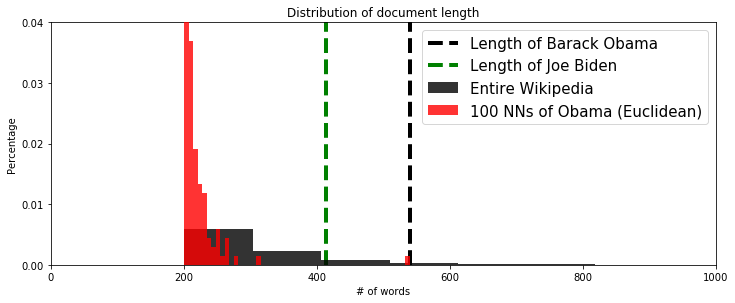

In [36]:
plt.figure(figsize=(10.5,4.5))
plt.hist(data['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean_df['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=nearest_neighbors_euclidean_df.iloc[0]['length'], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=int(data[data['name']=='Joe Biden']['length']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [37]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indexes = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
nearest_neighbors_cosine_df = pd.DataFrame({'distance':distances.flatten(), 'index':indexes.flatten(), 'name':data.iloc[indexes.flatten()]['name'], 'length':data.iloc[indexes.flatten()]['length']})
cols = ['index', 'name', 'length','distance']
nearest_neighbors_cosine_df[cols][:10]

,index,name,length,distance
35817,35817,Barack Obama,540,0.000000
24478,24478,Joe Biden,414,0.703139
38376,38376,Samantha Power,310,0.742982
57108,57108,Hillary Rodham Clinton,580,0.758358
38714,38714,Eric Stern (politician),255,0.770561
46140,46140,Robert Gibbs,257,0.784678
6796,6796,Eric Holder,232,0.788039
44681,44681,Jesse Lee (politician),216,0.790926
18827,18827,Henry Waxman,279,0.798323
2412,2412,Joe the Plumber,217,0.799466


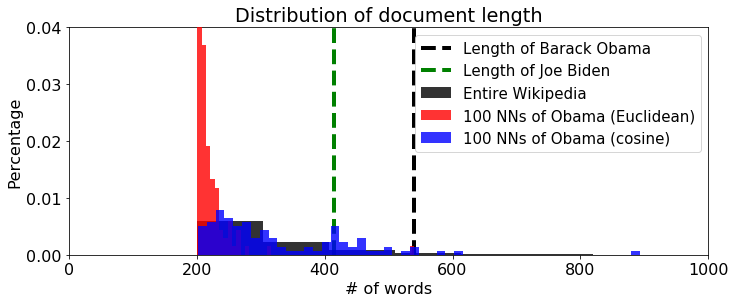

In [38]:
plt.figure(figsize=(10.5,4.5))
plt.hist(data['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean_df['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine_df['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=int(data[data['name']=='Barack Obama']['length']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=int(data[data['name']=='Joe Biden']['length']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()